# Sparkify EDA Workspace

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). It will be used for EDA to garner insights on what features will be useful to look into.

In [1]:
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import desc, asc, sum as Fsum
from pyspark.sql.functions import month, dayofmonth, dayofweek, hour

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Our first Python Spark SQL example") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '192.168.0.12'),
 ('spark.app.name', 'Our first Python Spark SQL example'),
 ('spark.driver.port', '50122'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1593551469893'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
print('Loading the data ...')
path = "mini_sparkify_event_data.json"
event_log = spark.read.json(path)
print('Data loaded!\n')

print('Cleaning the data ...')

# removes the empty user ID
event_log = event_log.filter(event_log.userId != "")

# Flags if a user cancelled at any point
flag_cancel_event = udf(lambda x:
                        1 if x == 'Cancellation Confirmation' else 0
                        , IntegerType())
event_log = event_log.withColumn('cancelled'
                                 , flag_cancel_event(event_log.page))

# all rows after cancel event set churned to 1 else 0
windowval = Window.partitionBy('userId')\
                    .orderBy(desc('ts'))\
                    .rangeBetween(Window.unboundedPreceding, 0)
event_log = event_log.withColumn('churned', Fsum('cancelled').over(windowval))
print('Data cleaned!\n')


print('Extracting useable features from datetime timestamp ...')
get_timestamp = udf(lambda x:
                    datetime.datetime.fromtimestamp(int(int(x)/1000))
                    , TimestampType())
event_log = event_log.withColumn('ts', get_timestamp(event_log.ts)) \
                    .withColumn('hour', hour('ts')) \
                    .withColumn('day', dayofmonth('ts')) \
                    .withColumn('month', month('ts')) \
                    .withColumn('weekday', dayofweek('ts'))
print('Features extracted and added to table!\n')

Loading the data ...
Data loaded!

Cleaning the data ...
Data cleaned!

Extracting useable features from datetime timestamp ...
Features extracted and added to table!



# 1. Explore the data

With churn defined, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. Start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

First define a function to normalise the data in a pandas dataframe.

In [6]:
def normalize_data(df):
    '''
    Maps data in pandas columns to between 0 and 1, i.e., normalises the data
    Takes into account churn vs no-churn so each set normalised independently
    Uses min-max normalisation
    Results in max value in column mapping to 1, min value mapping to 0 
    
    Inputs:
    - df: Pandas dataframe, expected to have only two columns
    
    Outputs:
    - df_normal: Pandas dataframe, normalised
    
    '''
    series = df.set_index(list(df.columns[:2]))
    temp = series.unstack('churned').fillna(0)
    df_normal = pd.DataFrame(((temp-temp.min()) / (temp.max()-temp.min())) \
                             .stack()).reset_index()
    df_normal = df_normal
                .rename(columns={df_normal.columns[-1]:'normalised_count'})
    return df_normal

Instantiate the temporary view to use in `spark.sql`.

In [11]:
event_log.createOrReplaceTempView('event_log_table')

## 1.1 Total Churn vs. Not

In [7]:
churned = event_log.select(['userId','churned'])\
                    .dropDuplicates()\
                    .groupby(event_log.churned).count()\
                    .toPandas()
user_levels = event_log.select(['userId','level'])\
                    .dropDuplicates()\
                    .groupby(event_log.level).count()\
                    .toPandas()

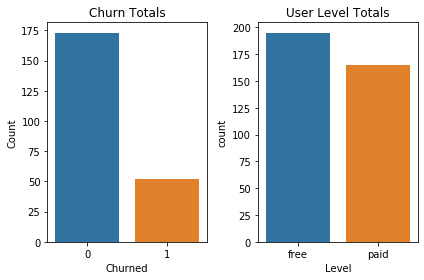

In [8]:
fig, axes = plt.subplots(1, 2)
sns.barplot(y='count', x='churned', data=churned, ax=axes[0])
sns.barplot(y='count', x='level', data=user_levels, ax=axes[1])

axes[0].set(xlabel='Churned', ylabel='Count')
axes[0].set_title('Churn Totals')

axes[1].set(xlabel='Level')
axes[1].set_title('User Level Totals')

fig.tight_layout()

## 1.2 Songsplays by hour, weekday and day of month

In [9]:
songs_in_hour = event_log.filter(event_log.page=='NextSong') \
                        .groupby([event_log.hour, event_log.churned]).count()\
                        .orderBy(event_log.hour.cast('float'))\
                        .toPandas()
songs_in_hour = normalize_data(songs_in_hour)
songs_in_weekday = event_log.filter(event_log.page=='NextSong')\
                        .groupby([event_log.weekday, event_log.churned])\
                        .count()\
                        .orderBy(event_log.weekday.cast('float'))\
                        .toPandas()
songs_in_weekday = normalize_data(songs_in_weekday)
songs_in_day = event_log.filter(event_log.page=='NextSong')\
                        .groupby([event_log.day, event_log.churned]).count()\
                        .orderBy(event_log.day.cast('float'))\
                        .toPandas()
songs_in_day = normalize_data(songs_in_day)

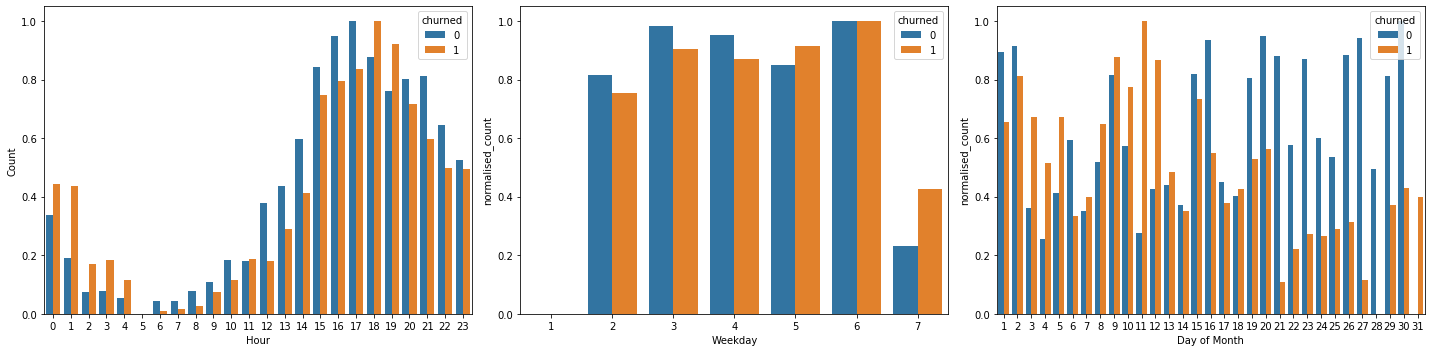

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,5))

sns.barplot(y='normalised_count', x='hour',
            data=songs_in_hour, hue='churned', ax=axes[0])
axes[0].set(xlabel='Hour', ylabel='Count')

sns.barplot(y='normalised_count', x='weekday',
            data=songs_in_weekday, hue='churned', ax=axes[1])
axes[1].set(xlabel='Weekday')

sns.barplot(y='normalised_count', x='day',
            data=songs_in_day, hue='churned', ax=axes[2])
axes[2].set(xlabel='Day of Month')

fig.tight_layout()

### Thoughts:

These visuals indicate that customers who go on to cancel a subscription tend to use the app at different times of the day and at different times in the month to those who keep a subscription. In the feature engineering section, will look to incorporate this.

## 1.3 Number of unique songs and artists

In [15]:
num_unique_songs = event_log.select(['userId','song','churned'])\
                            .dropDuplicates()\
                            .groupby(event_log.userId, event_log.churned)\
                            .count()

In [17]:
unique_songs_query = spark.sql('''
    SELECT
        distinct userId
        , count(distinct song) as unique_songs
        , max(churned) as churned
    FROM
        event_log_table
    WHERE
        page="NextSong"
    GROUP BY
        userId
    ORDER BY
        unique_songs desc
''')
unique_songs = unique_songs_query.toPandas()

unique_artists_query = spark.sql('''
    SELECT
        distinct userId
        , count(distinct artist) as unique_artists
        , max(churned) as churned
    FROM
        event_log_table
    WHERE
        page="NextSong"
    GROUP BY
        userId
    ORDER BY
        unique_artists desc
''')
unique_artists = unique_artists_query.toPandas()

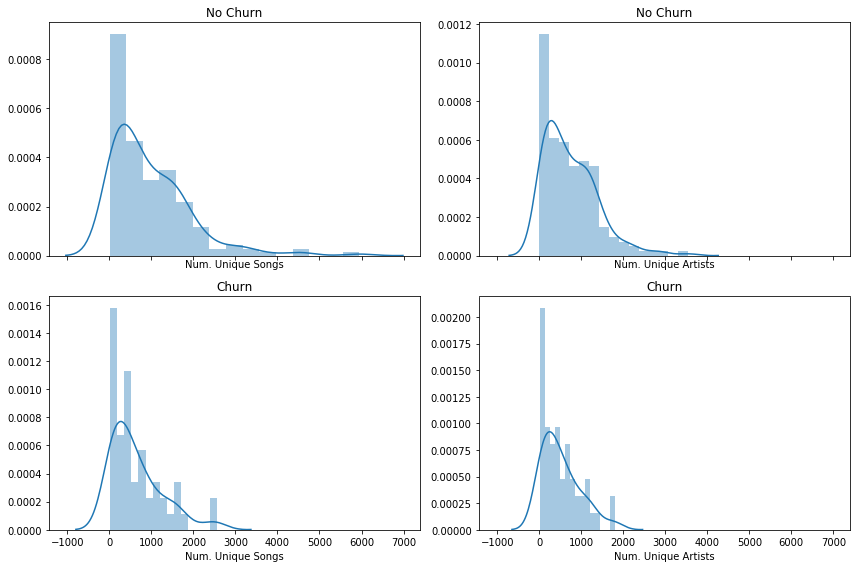

In [36]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)

sns.distplot(a=unique_songs[unique_songs['churned']==0]['unique_songs']
             , bins=15
             , ax=axes[0,0])
sns.distplot(a=unique_songs[unique_songs['churned']==1]['unique_songs']
             , bins=15
             , ax=axes[1,0])

sns.distplot(a=unique_artists[unique_artists['churned']==0]['unique_artists']
             , bins=15
             , ax=axes[0,1])
sns.distplot(a=unique_artists[unique_artists['churned']==1]['unique_artists']
             , bins=15
             , ax=axes[1,1])

axes[0,0].set_title('No Churn')
axes[0,0].set(xlabel='Num. Unique Songs')
axes[1,0].set(xlabel='Num. Unique Songs')
axes[1,0].set_title('Churn')
axes[0,1].set_title('No Churn')
axes[0,1].set(xlabel='Num. Unique Artists')
axes[1,1].set(xlabel='Num. Unique Artists')
axes[1,1].set_title('Churn')

fig.tight_layout()

### Thoughts:

The distributions on the unique number of songs and artists a use listens to looks very similar for churn vs. no churn; the customer who stay have longer tails on their distributions. This may be a symptom of the small sample size. Nevretheless, this will not be built as a feature for now.

## 1.4 Non-Songplay Page Interactions

In [58]:
page_counts = event_log.filter(event_log.page != 'NextSong')\
                        .select([event_log.page, event_log.churned])\
                        .groupby([event_log.page, event_log.churned]).count()\
                        .toPandas().sort_values('count', ascending=False)

page_counts = normalize_data(page_counts)
page_counts = page_counts.sort_values('normalised_count', ascending=False)

In [59]:
page_counts = page_counts.sort_values('normalised_count', ascending=False)

[Text(0, 0, 'Thumbs Up'),
 Text(0, 0, 'Home'),
 Text(0, 0, 'Add to Playlist'),
 Text(0, 0, 'Roll Advert'),
 Text(0, 0, 'Add Friend'),
 Text(0, 0, 'Logout'),
 Text(0, 0, 'Thumbs Down'),
 Text(0, 0, 'Downgrade'),
 Text(0, 0, 'Settings'),
 Text(0, 0, 'Help'),
 Text(0, 0, 'Upgrade'),
 Text(0, 0, 'About'),
 Text(0, 0, 'Save Settings'),
 Text(0, 0, 'Cancel'),
 Text(0, 0, 'Cancellation Confirmation'),
 Text(0, 0, 'Error'),
 Text(0, 0, 'Submit Upgrade'),
 Text(0, 0, 'Submit Downgrade')]

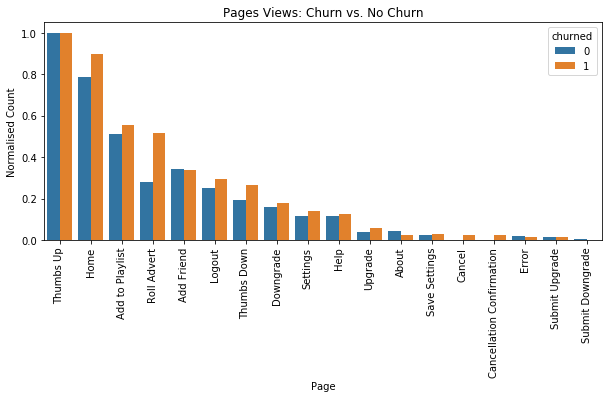

In [61]:
plt.figure(figsize=(10,4))
ax = sns.barplot(y='normalised_count', x='page',
                 data=page_counts, hue='churned')
ax.set(xlabel='Page', ylabel='Normalised Count')
ax.set_title('Pages Views: Churn vs. No Churn')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Thoughts:

Difference between the churn vs. no churn looks significant enough to use the number of interactions with each of these pages as features in the model to predict churn.